<a href="https://colab.research.google.com/github/pgpa123/MBA_Ciencia_Dados/blob/main/TCC_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregar bibliotecas

In [ ]:
#!pip uninstall matplotlib
!pip install matplotlib==3.4.2
# Após executar esse comando reinicializar o ambiente de execução

In [90]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
import pandas as pd
import nltk
import string
nltk.download('punkt')
from nltk import tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from string import punctuation
from unidecode import unidecode
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import seed
from tensorflow.random import set_seed
import gensim
from gensim.models import Word2Vec,KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
from tensorflow import keras
from keras.layers.core import Dense, Activation, Dropout
import tensorflow as tf
from numpy import array
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding, GlobalMaxPooling1D
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
import statistics
from statistics import mode, mean, median, stdev
from scipy import stats

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Construir Dataset

In [92]:
#Carrega a amostra de AIIMs em uma lista
AIIMs = pd.read_excel('/content/drive/MyDrive/MBA/Importacao - Amostra/amostra_85_1_e.xlsx',  sheet_name = 'Amostra', usecols='A')
AIIMs = [str(x) for x in AIIMs['AIIM']]
print('Qte AIIMS', len(AIIMs), '\n', AIIMs[0:10])

Qte AIIMS 315 
 ['4056292', '4057038', '4057318', '4057733', '4058190', '4058716', '4058828', '4058907', '4059161', '4059192']


In [93]:
#Carrega defesas e as coloca no Dataframe Defesas de acordo com a amostra de AIIMs
Defesas=pd.DataFrame(columns=["AIIM","Defesa"])
for aiim in AIIMs:
  f=open("/content/drive/MyDrive/MBA/Importacao - Amostra/Amostra_Art_85_1_e/"+aiim+".txt", encoding="ISO-8859-1")
  x=f.read()
  Defesas.loc[len(Defesas.index)] = [aiim,x]
Defesas.set_index('AIIM', inplace = True)
print('Qte de defesas', len(Defesas), '\n', Defesas.head()) 

Qte de defesas 315 
                                                     Defesa
AIIM                                                      
4056292  8\nLIMA 278\n\nFRAGOSO\nMARINELLO\n\nADVOGADOS...
4057038  | » ot\nBraga Nascimenito\n; @ ZilIO apvocavos...
4057318  270\n\nAÁAOAGCO\n\nYour Agriculture Company\n\...
4057733  De\n\noo\nOO\nFE\n\nFABIO KADI\n\nADVOGADOS\n\...
4058190  149\nMINA! VINHAS E REDENSCHI\n\nILUSTRÍSSIMOS...


In [94]:
#Carrega resultados dos julgamentos
Julgados = pd.read_excel('/content/drive/MyDrive/MBA/Importacao - Amostra/amostra_85_1_e.xlsx',  sheet_name = 'Amostra', usecols=['AIIM','descr_decisao'],
              dtype={'AIIM': str, 'descr_decisao': str})
Julgados=Julgados.dropna()
Julgados.set_index('AIIM', inplace = True)
print('Qte de resultados', len(Julgados), '\n', Julgados.head())

Qte de resultados 315 
         descr_decisao
AIIM                 
4056292      Reduzido
4057038       Mantido
4057318     Cancelado
4057733     Cancelado
4058190      Reduzido


In [95]:
#Monta o DataFrame de Análise
df=pd.merge(Defesas, Julgados, left_index=True, right_index=True)
df.sample(10)

,Defesa,descr_decisao
AIIM,,
4042779,558\nBraga Nascimento *\n\ne Zilio ADVOGADOS A...,Reduzido
4029523,Brazuna 215\nRuschmann\nPiovesan RUA TENENTE N...,Mantido
4058907,. 37\n== | SENAT:\n= ee ee ee\nEXCELENTISSIMO ...,Mantido
4011159,Espallargas . Gonzalez «Sampaio.Fidalgo OU U b...,Mantido
4047168,| : 3  61\nDeus & Dias\n: Sociedade de Advoga...,Reduzido
4002574,Protocolo Pagina | de |\nfeo P at4\nSECRETARIA...,Mantido
4041413,<e 76\n| | Deus & Dias\n| Sociedade de Advoga...,Reduzido
4055599,ih.\nDeus & Dias\nSociedade de Advogaaos\nts\...,Mantido
4142170,FRANCO MONTORO E PEIXOTO 2767\n\nADVOGADOS ASS...,Mantido


In [96]:
#Criar dígitos para as Classes
df["decisao_dig"]=df["descr_decisao"].replace(["Mantido","Reduzido","Cancelado"],[0,1,2])
df.sample(10)

,Defesa,descr_decisao,decisao_dig
AIIM,,,
4000342,"LACAZ MARTINS, R. PaDRE JoXO ManoEL, 923 QL\nP...",Cancelado,2
4110822,COVAC\n\nILUSTRISSIMO SENHOR JULGADOR TRIBUTAR...,Mantido,0
4055439,76\n\n \n\nRaia\nNA VEe\n2.7 EA Vo\n\nILMO. SR...,Cancelado,2
4145810,Ke 93\n\nILMO. SR. JULGADOR DA DELEGACIA REGIO...,Cancelado,2
4134448,BASSIL HANNANEJM as?\n\nADVOGADOS\n\nILUSTRÍSS...,Mantido,0
4090624,/\nal | ; 7 od\non ILUSTRISSIMO SENHOR DOUTOR ...,Mantido,0
4001493,> Espallargas Gonzalez Sampaio a5 Guan C ioche...,Reduzido,1
4056292,8\nLIMA 278\n\nFRAGOSO\nMARINELLO\n\nADVOGADOS...,Reduzido,1
4042175,"15386\n\nSTOCCHE, FORBES, PADIS, FILIZZOLA, CL...",Reduzido,1


In [97]:
#Verifica balanceamento
x=pd.DataFrame(df.descr_decisao.value_counts())
type(x)
x['Perc']=round(x['descr_decisao']/x['descr_decisao'].sum(),2)
x

,descr_decisao,Perc
Mantido,124,0.39
Reduzido,106,0.34
Cancelado,85,0.27


# Funções Exploratórias

In [98]:
#verifica palavras mais frequentes
def frequencia(texto, coluna_texto, decisao):
    texto_mantido=df.query(decisao)
    todas_palavras=[texto for texto in texto_mantido[coluna_texto]]
    todas_palavras=" ".join(todas_palavras)
    token_espaco=tokenize.WhitespaceTokenizer()
    token_frase=token_espaco.tokenize(todas_palavras)
    frequencia=nltk.FreqDist(token_frase)
    df_frequencia=pd.DataFrame({"Palavra": list(frequencia.keys()),"Freq": list(frequencia.values())})
    return df_frequencia.nlargest(columns="Freq",n=10)

In [99]:
# contar qte de linhas, palavras e palavras únicas
def conta_linhas(descr_decisao,coluna):
  df2=df[df['descr_decisao']==descr_decisao].copy()
  linhas = 0
  palavras=[]
  pal_uni=[]
  for i in range(len(df2)):
    CoList2 = df[coluna].iloc[i].lower()
    comp=CoList2.split()
    comp_uni=set(comp)
    palavras.append(len(comp))
    pal_uni.append(len(comp_uni))
    CoList = df2[coluna].iloc[i].split("\n")
    for i in CoList:
      if i:
        linhas += 1
  palavras=sum(palavras)
  palavras_unicas=sum(pal_uni)
  return linhas,palavras,palavras_unicas       

In [100]:
variaveis={'linhas':int(),"palavras":int(),'palavras únicas':int()}
df_contador=pd.DataFrame(variaveis,index=['Mantido','Reduzido','Cancelado'])
df_contador.dtypes

linhas             int64
palavras           int64
palavras únicas    int64
dtype: object

In [101]:
linhas,palavras,palavras_unicas  = conta_linhas("Mantido","Defesa")
df_contador.loc['Mantido',:]=[linhas,palavras,palavras_unicas]

In [102]:
linhas,palavras,palavras_unicas  = conta_linhas("Reduzido","Defesa")
df_contador.loc['Reduzido',:]=[linhas,palavras,palavras_unicas]

In [103]:
linhas,palavras,palavras_unicas  = conta_linhas("Cancelado","Defesa")
df_contador.loc['Cancelado',:]=[linhas,palavras,palavras_unicas]

In [104]:
# select numeric columns and calculate the sums
sums = df_contador.select_dtypes(pd.np.number).sum().rename('total')
# append sums to the data frame
df_contador.append(sums)

<ipython-input-104-937171bb3776>:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  sums = df_contador.select_dtypes(pd.np.number).sum().rename('total')


,linhas,palavras,palavras únicas
Mantido,74432,731144,223535
Reduzido,81615,639240,196458
Cancelado,58973,541140,165845
total,215020,1911524,585838


In [105]:
df_contador.dtypes

linhas             int64
palavras           int64
palavras únicas    int64
dtype: object

In [106]:
# Palavras mais frequentes para a categoria mantido
frequencia(df,'Defesa', "descr_decisao=='Mantido'")

,Palavra,Freq
36,de,32318
79,a,17348
142,do,15642
338,o,13418
91,da,12541
44,e,11329
208,que,9995
89,em,6167
64,no,5297
364,-,4710


In [107]:
frequencia(df,'Defesa', "descr_decisao=='Reduzido'")

,Palavra,Freq
21,de,34651
73,a,17905
37,do,17098
53,o,14701
185,da,12657
71,e,11669
275,que,11378
2074,|,6942
62,em,6456
50,no,5495


In [108]:
frequencia(df,'Defesa', "descr_decisao=='Cancelado'")

,Palavra,Freq
14,de,23541
64,do,11709
198,a,11541
51,o,10043
72,da,8965
39,e,7794
206,que,7416
90,em,4590
48,no,3801
106,-,3758


In [109]:
#pareto das palavras
def pareto(texto, coluna_texto, decisao, quantidade):
    texto_mantido=df.query(decisao) 
    todas_palavras=" ".join(texto for texto in texto_mantido[coluna_texto])
    token_espaco=tokenize.WhitespaceTokenizer()
    token_frase=token_espaco.tokenize(todas_palavras)
    frequencia=nltk.FreqDist(token_frase)
    df_frequencia=pd.DataFrame({"Token": list(frequencia.keys()),"Frequencia": list(frequencia.values())})
    df_frequencia.nlargest(columns="Frequencia",n=quantidade)
    plt.figure(figsize=(12,8))
    ax=sns.barplot(data=df_frequencia.nlargest(columns="Frequencia",n=quantidade),x="Token", y="Frequencia", color='gray')
    ax.set(ylabel="Contagem")
    plt.show()

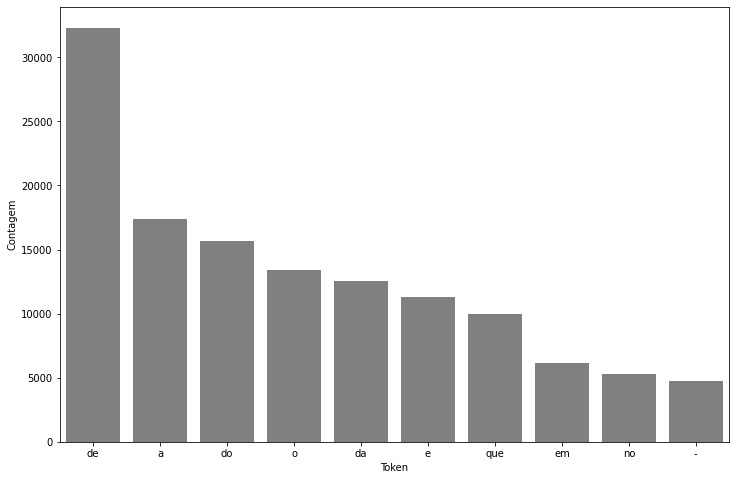

In [110]:
pareto(df,'Defesa',"descr_decisao=='Mantido'",10)

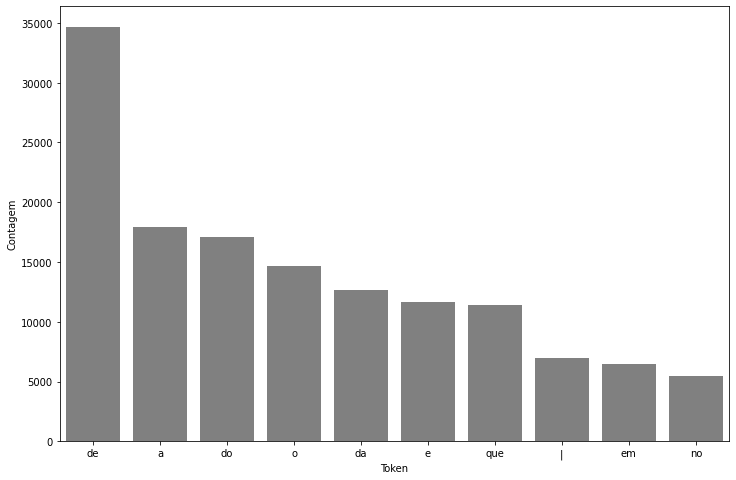

In [111]:
pareto(df,"Defesa","descr_decisao=='Reduzido'",10)

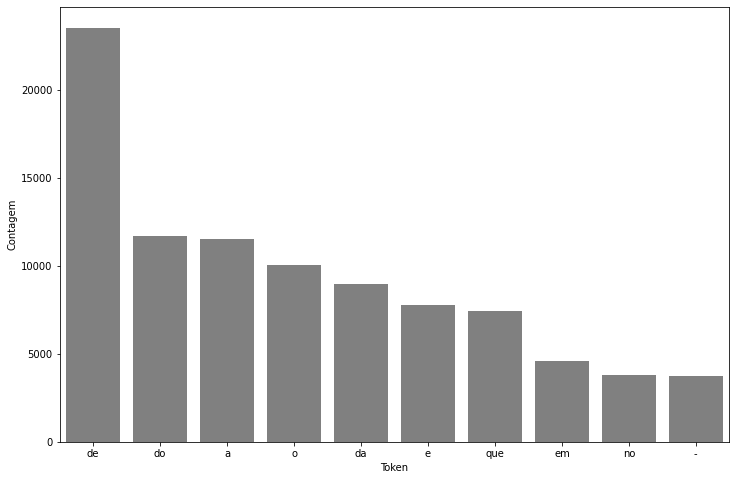

In [112]:
pareto(df,"Defesa","descr_decisao=='Cancelado'",10)

In [113]:
from math import trunc
# Histograma do tamanho das defesas (qte palavras)
def tam_def():
  print(len(df['Defesa']))
  tam=[]
  for d in range(len(df['Defesa'])):
    palavras=df['Defesa'][d].split()
    tam.append(len(palavras))
    moda=mode(tam)
    media=trunc(mean(tam))
    mediana=trunc(median(tam))
  counts, edges, bars = plt.hist(tam, align='right', color='grey', edgecolor='black', bins = 20 )
  #plt.xlabel('Qte de tokens')
  plt.ylabel('Qte. de defesas')
  plt.suptitle('Distribuição do tamanho das defesas', fontsize=12)
  plt.title('moda: ' + str(moda)+ '  média: '+ str(media)+ '  mediana: '+ str(mediana), fontsize=10)
  plt.bar_label(bars)
  print(stats.describe(tam))
  print(min(tam),max(tam))

315
DescribeResult(nobs=315, minmax=(164, 37265), mean=5640.793650793651, variance=19577833.731169753, skewness=2.0126764394100616, kurtosis=8.676269519777811)
164 37265


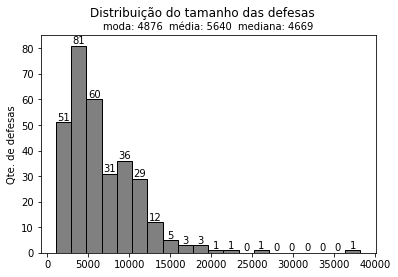

In [114]:
 tam_def()

In [115]:
# Histograma do tamanho das defesas (qte palavras)
def tam_def(decisao):
  x=df.query(decisao)
  print(len(x['Defesa']))
  tam=[]
  for d in range(len(x)):
    palavras=x['Defesa'][d].split()
    tam.append(len(palavras))
    moda=mode(tam)
    media=trunc(mean(tam))
    mediana=trunc(median(tam))
  counts, edges, bars = plt.hist(tam, align='right', color='grey', edgecolor='black', bins = 20 )
  #plt.xlabel('Qte de palavras')
  plt.ylabel('Qte de defesas')
  plt.suptitle('Distribuição do tamanho das defesas', fontsize=12)
  plt.title('moda: ' + str(moda)+ '  média: '+ str(media)+ '  mediana: '+ str(mediana), fontsize=10)
  plt.bar_label(bars)

85


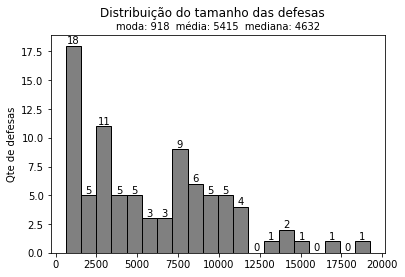

In [116]:
tam_def("descr_decisao=='Cancelado'")

106


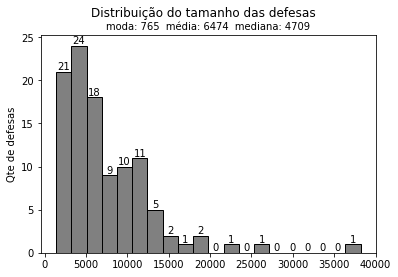

In [117]:
tam_def("descr_decisao=='Reduzido'")

124


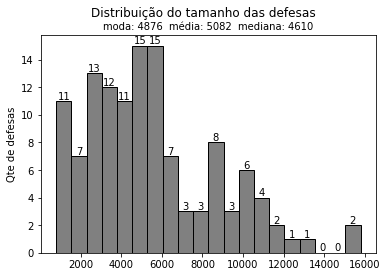

In [118]:
tam_def("descr_decisao=='Mantido'")

In [119]:
# Boxplot do tamanho das defesas
def bp_tam_def(decisao,coluna):
  x=df.query(decisao)
  print(len(x[coluna]))
  tam=[]
  for d in range(len(x)):
    palavras=x[coluna][d].split()
    tam.append(len(palavras))
  return tam

124
106
85
5082.290322580645 6474.509433962264 5415.858823529412


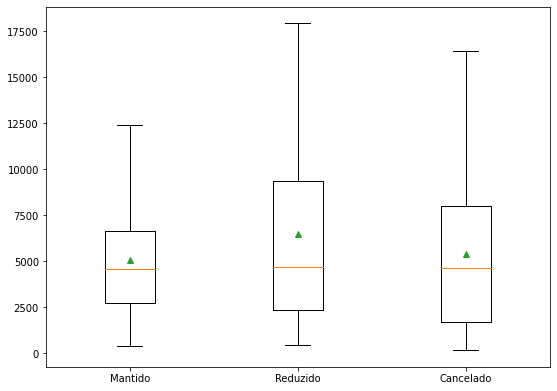

In [120]:
M=bp_tam_def("descr_decisao=='Mantido'",'Defesa')
R=bp_tam_def("descr_decisao=='Reduzido'",'Defesa')
C=bp_tam_def("descr_decisao=='Cancelado'",'Defesa')
print(np.mean(M),np.mean(R),np.mean(C))
data=[M,R,C]
labels=['Mantido','Reduzido','Cancelado']
ticks=[1,2,3,]
fig = plt.figure(figsize =(7, 5))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(data, showfliers=False, showmeans=True)
# show plot
plt.xticks(ticks,labels)
plt.show()

# Limpeza da base dados

In [121]:
def pre_processa():
  #transformar todo texto em minúsculo
  df['Defesa']=df['Defesa'].str.lower()
  #carrega palavras irrelevantes
  palavras_irrelevantes=nltk.corpus.stopwords.words("portuguese")
  lista=['/',', ','.',',', ' ',': ',' (', ') ','-', ' \x97 ','são','paulo','lei','art.','nº','04538-905-','1','', '75', 
       'artigo75', 'art.75','13.457','18.457','sp','rua','0','sao','que','i','18/03/2009.','/sp','av.','r','Documento enviado mediante uso de assinatura eletrônica',
       'de acordo com o caput do Art. 75','Lei 13.457 de 18/03/2009']
  palavras_irrelevantes.append('paulo')
  palavras_irrelevantes.extend(lista) 
  #carrega pontuação
  pontuacao=list()
  for ponto in punctuation:
      pontuacao.append(ponto)
  pontuacao_stopwords=pontuacao+palavras_irrelevantes 
  #retirar stopwords e pontuação
  frase_processada=list()
  for opiniao in df['Defesa']:
      nova_frase=list()
      token_espaco=tokenize.WhitespaceTokenizer()
      palavras_texto=token_espaco.tokenize(opiniao)
      for palavra in palavras_texto:
         if palavra not in pontuacao+palavras_irrelevantes and len(palavra)>1:
              nova_frase.append(unidecode(palavra)) #retira acentuação e tokens de um caracter           
      frase_processada.append(" ".join(nova_frase))       
  df['Defesa_limpa']=frase_processada 
  for i in range(len(df['Defesa_limpa'])):
    df['Defesa_limpa'][i]=re.sub(r"documento enviado mediante uso assinatura eletronica|paulo|,|que|/sp|\se\s"
    ," ",df['Defesa_limpa'][i])   

In [122]:
pre_processa()

<ipython-input-121-fc883e760950>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Defesa_limpa'][i]=re.sub(r"documento enviado mediante uso assinatura eletronica|paulo|,|que|/sp|\se\s"


In [123]:
# Palavras mais frequentes para a categoria mantido
frequencia(df,'Defesa_limpa', "descr_decisao=='Mantido'")

,Palavra,Freq
196,artigo,2479
274,icms,2092
12,estado,1889
283,caput,1750
275,nao,1732
240,importacao,1676
282,acordo,1488
73,multa,1454
440,sobre,1381
298,juros,1277


In [124]:
# Palavras mais frequentes para a categoria reduzido
frequencia(df,'Defesa_limpa', "descr_decisao=='Reduzido'")

,Palavra,Freq
275,artigo,2652
131,caput,2175
181,icms,2123
3093,nao,1671
130,acordo,1650
50,direito,1459
30,estado,1413
136,impugnante,1362
216,juros,1326
3372,ndeg,1259


In [125]:
# Palavras mais frequentes para a categoria cancelado
frequencia(df,'Defesa_limpa', "descr_decisao=='Cancelado'")

,Palavra,Freq
272,artigo,1872
157,icms,1600
91,caput,1310
17,estado,1267
90,acordo,1046
610,sobre,947
50,multa,937
1553,juros,933
12,direito,931
48,infracao,927


124
106
85
3060.8951612903224 3864.4056603773583 3257.0


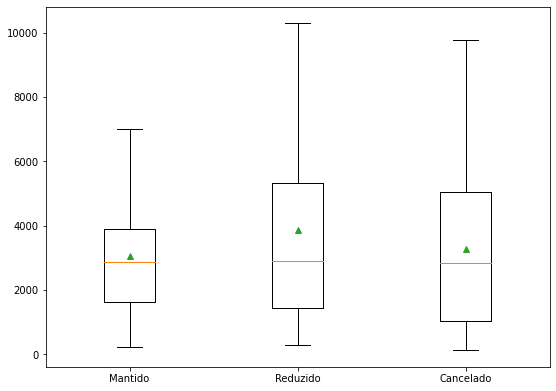

In [126]:
M=bp_tam_def("descr_decisao=='Mantido'",'Defesa_limpa')
R=bp_tam_def("descr_decisao=='Reduzido'",'Defesa_limpa')
C=bp_tam_def("descr_decisao=='Cancelado'",'Defesa_limpa')
data=[M,R,C]
print(np.mean(M),np.mean(R),np.mean(C))
labels=['Mantido','Reduzido','Cancelado']
ticks=[1,2,3,]
fig = plt.figure(figsize =(7, 5))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(data, showfliers=False, showmeans=True)
# show plot
plt.xticks(ticks,labels)
plt.show()

In [127]:
variaveis={'defesas':int(),"palavras":int(),'palavras únicas':int()}
df_contador=pd.DataFrame(variaveis,index=['Mantido','Reduzido','Cancelado'])
df_contador.dtypes

defesas            int64
palavras           int64
palavras únicas    int64
dtype: object

In [128]:
linhas,palavras,palavras_unicas  = conta_linhas("Mantido","Defesa_limpa")
df_contador.loc['Mantido',:]=[linhas,palavras,palavras_unicas]

In [129]:
linhas,palavras,palavras_unicas  = conta_linhas("Reduzido","Defesa_limpa")
df_contador.loc['Reduzido',:]=[linhas,palavras,palavras_unicas]

In [130]:
linhas,palavras,palavras_unicas  = conta_linhas("Cancelado","Defesa_limpa")
df_contador.loc['Cancelado',:]=[linhas,palavras,palavras_unicas]

In [131]:
# select numeric columns and calculate the sums
sums = df_contador.select_dtypes(pd.np.number).sum().rename('total')
# append sums to the data frame
df_contador.append(sums)

<ipython-input-131-937171bb3776>:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  sums = df_contador.select_dtypes(pd.np.number).sum().rename('total')


,defesas,palavras,palavras únicas
Mantido,124,440689,194444
Reduzido,106,385356,171034
Cancelado,85,326322,144614
total,315,1152367,510092


# Salvar o dataset limpo

In [132]:
df.to_pickle('/content/drive/MyDrive/Colab Notebooks/Defesas.pkl') 

# Carregar dataset limpo

In [133]:
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Defesas.pkl')
df

,Defesa,descr_decisao,decisao_dig,Defesa_limpa
AIIM,,,,
4056292,8\nlima 278\n\nfragoso\nmarinello\n\nadvogados...,Reduzido,1,lima 278 fragoso marinello advogados ilustriss...
4057038,| » ot\nbraga nascimenito\n; @ zilio apvocavos...,Mantido,0,ot braga nascimenito zilio apvocavos associado...
4057318,270\n\naáaoagco\n\nyour agriculture company\n\...,Cancelado,2,270 aaaoagco your agriculture company agco bra...
4057733,de\n\noo\noo\nfe\n\nfabio kadi\n\nadvogados\n\...,Cancelado,2,oo oo fe fabio kadi advogados 284.633 ilustris...
4058190,149\nmina! vinhas e redenschi\n\nilustríssimos...,Reduzido,1,149 mina! vinhas redenschi ilustrissimos senho...
...,...,...,...,...
4145810,ke 93\n\nilmo. sr. julgador da delegacia regio...,Cancelado,2,ke 93 ilmo. sr. julgador delegacia regional tr...
4146432,"silva filho """"ô\n\n \n\nilustríssimo senhor ch...",Cancelado,2,"silva filho """"o ilustrissimo senhor chefe post..."
4096928,1133\nse gaia silva gaede\n\nadvogados\n\nst\n...,Cancelado,2,1133 gaia silva gaede advogados st ss ilustris...


# Modelos AM

## Sem Word2Vec

### Cria base de treino e de teste

In [134]:
# Função para vetorização tfidf
def treino_teste():
  # Spliting into X & y
 
  X=df['Defesa_limpa']
  y=df['descr_decisao'].values

  # Building a TF IDF matrix out of the corpus of reviews
  td = TfidfVectorizer(max_features = 6000)
  X = td.fit_transform(X).toarray()

  # Splitting into training & test subsets
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  return X_train, X_test, y_train, y_test, td, X, y 

### Cria função de classificação

In [135]:
# função de classificação 

def modeloam(classifier, semente, nome):
  from sklearn.naive_bayes import MultinomialNB
  from sklearn.linear_model import LogisticRegression
  from sklearn.tree import DecisionTreeClassifier
  from sklearn import svm
  from sklearn.ensemble import RandomForestClassifier
                               
  X_train, X_test, y_train, y_test, td, X, y = treino_teste()
 
  # Training the classifier & predicting on test data

  seed(semente)

  classifier = classifier
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)

  # Classification metrics
  from sklearn.metrics import accuracy_score, classification_report
  classification_report = classification_report(y_test, y_pred)

  print('\n Acurácia: ', accuracy_score(y_test, y_pred))
  print('\nRelatório da classificação')
  print('======================================================')
  print('\n', classification_report)

  ## Display the visualization of the Confusion Matrix.
  plt.show()

  # matriz de confusão
  cf_matrix=confusion_matrix(y_test, y_pred, labels=["Cancelado","Mantido","Reduzido"])
  ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='gray_r')
  
  ax.set_title(nome + ' - Matriz de Confusão (%)\n\n');
  ax.set_xlabel('\nValores preditos ')
  ax.set_ylabel('Valores reais ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(["Cancelado","Mantido","Reduzido"])
  ax.yaxis.set_ticklabels(["Cancelado","Mantido","Reduzido"])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

  print('\n')

  # matriz de confusão 2
  cf_matrix2=confusion_matrix(y_test,y_pred,)
  ax2 = sns.heatmap(cf_matrix2, annot=True, cmap='gray_r')
  
  ax2.set_title(nome + ' - Matriz de Confusão (qte)\n\n');
  ax2.set_xlabel('\nValores preditos')
  ax2.set_ylabel('Valores reais ');

  ## Ticket labels - List must be in alphabetical order
  ax2.xaxis.set_ticklabels(["Cancelado","Mantido","Reduzido"])
  ax2.yaxis.set_ticklabels(["Cancelado","Mantido","Reduzido"])

  ## Display the visualization of the Confusion Matrix.
  plt.show()


  import seaborn as sn
  conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

  sn.heatmap(conf_matrix, annot=True)
  plt.show()
 

### Random Forest


 Acurácia:  0.7619047619047619

Relatório da classificação

               precision    recall  f1-score   support

   Cancelado       0.79      0.65      0.71        17
     Mantido       0.76      0.85      0.80        26
    Reduzido       0.75      0.75      0.75        20

    accuracy                           0.76        63
   macro avg       0.76      0.75      0.75        63
weighted avg       0.76      0.76      0.76        63



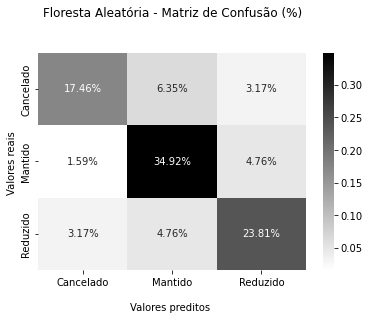

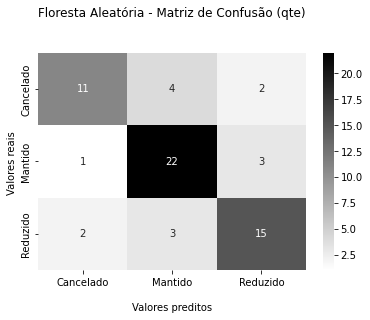

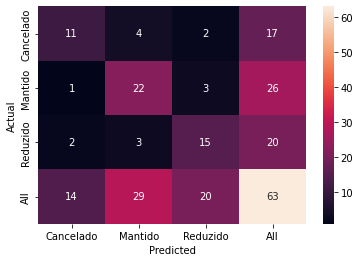

In [136]:
# Classificação com Random Forest
from sklearn.ensemble import RandomForestClassifier
modeloam(RandomForestClassifier(n_estimators=350,criterion='gini',max_depth=50,max_features=500, max_samples=189),1,'Floresta Aleatória')

### *Regressão* Logística

In [137]:
import os
os.getcwd()

'/content'


 Acurácia:  0.7142857142857143

Relatório da classificação

               precision    recall  f1-score   support

   Cancelado       0.61      0.65      0.63        17
     Mantido       0.79      0.73      0.76        26
    Reduzido       0.71      0.75      0.73        20

    accuracy                           0.71        63
   macro avg       0.71      0.71      0.71        63
weighted avg       0.72      0.71      0.72        63



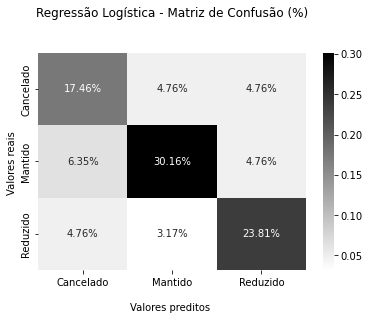

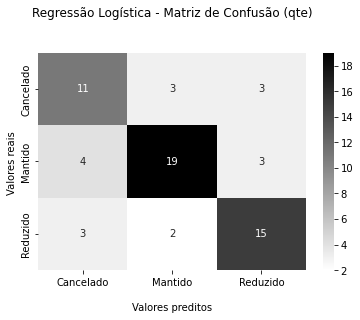

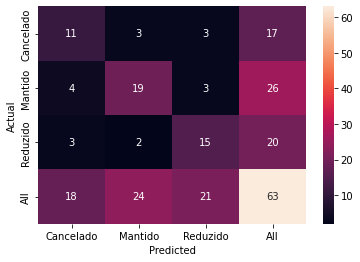

In [138]:
#Regressão Logística
modeloam(LogisticRegression(solver = "saga", class_weight="balanced", max_iter = 6000),1, 'Regressão Logística')

## Com Word2Vec

### Random Forest com Word2Vec

In [139]:
#cria estrutura chave-vetor
modelo = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/curso_word2vec/cbow_s300.txt', encoding='utf-8', unicode_errors='ignore')

In [140]:
# Tokenizar defesas
def tokenizador(texto):
   tokens_validos=[]
   tokens_validos=(nltk.word_tokenize(texto))   
   return tokens_validos 

In [141]:
# Combinação dos vetores das palavras de uma defesa em um único vetor para essa defesa
def combinacao_de_vetores_por_soma(palavras, modelo):
    vetor_resultante=np.zeros((1,300))
    for pn in palavras:
        try:
            vetor_resultante += modelo.get_vector(pn)
        except KeyError:
            pass
    return vetor_resultante

In [142]:
# Vetoriza o corpus. Cada defesa é uma linha da matriz linhas x 300 dimensões
def matriz_vetores(textos, modelo):
    x=len(textos)
    y=300
    matriz=np.zeros((x,y))

    for i in range(x):
        palavras=tokenizador(textos.iloc[i])
        matriz[i]=combinacao_de_vetores_por_soma(palavras, modelo)        
    return matriz 

In [143]:
# dividir dataset em treino e teste sem tfidf

# Spliting into x & y
x=df['Defesa_limpa']
y=df['descr_decisao'].values
#y = df['descr_decisao'].map({'Mantido':0,'Reduzido':1,'Cancelado':2})

# Splitting into training & test subsets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)

In [144]:
# Vetorizando as defesas com base no CBOWs_300 
matriz_vetores_treino_cbow = matriz_vetores(x_train, modelo)
matriz_vetores_teste_cbow = matriz_vetores(x_test, modelo)
print(matriz_vetores_treino_cbow.shape)
print(matriz_vetores_teste_cbow.shape) 

(252, 300)
(63, 300)


In [145]:
# Classificador Word2Vec 
def algoritmo(classifier, semente, alg):
  from sklearn.naive_bayes import MultinomialNB
  from sklearn.linear_model import LogisticRegression
  from sklearn.tree import DecisionTreeClassifier
  from sklearn import svm
  from sklearn.ensemble import RandomForestClassifier

  seed(semente)

  # Training the classifier & predicting on test data

  classifier = classifier
  classifier.fit(matriz_vetores_treino_cbow, y_train)
  y_pred = classifier.predict(matriz_vetores_teste_cbow)

  print('Mantido','\n', np.count_nonzero(y_test=='Mantido'),'\n', 'Reduzido','\n', np.count_nonzero(y_test=='Reduzido'))

  # Classification metrics
  from sklearn.metrics import accuracy_score, classification_report
  classification_report = classification_report(y_test, y_pred)

  print('\n Acurácia: ', accuracy_score(y_test, y_pred))
  print('\nRelatório de Classificação')
  print('======================================================')
  print('\n', classification_report)

  # matriz de confusão
  cf_matrix=confusion_matrix(y_test, y_pred, labels=["Cancelado","Mantido","Reduzido"])
  ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='gray_r')
  
  ax.set_title(alg +' com Word2Vec (%)\n\n');
  ax.set_xlabel('\nValores preditos')
  ax.set_ylabel('Valores Reais ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(["Cancelado","Mantido","Reduzido"])
  ax.yaxis.set_ticklabels(["Cancelado","Mantido","Reduzido"])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

  print('\n')

  # matriz de confusão 2
  cf_matrix2=confusion_matrix(y_test,y_pred)
  ax = sns.heatmap(cf_matrix2, annot=True, cmap='gray_r')
  
  ax.set_title(alg+' com Word2Vec (qte)\n');
  ax.set_xlabel('\nValores preditos')
  ax.set_ylabel('Valores Reais ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(["Cancelado","Mantido","Reduzido"])
  ax.yaxis.set_ticklabels(["Cancelado","Mantido","Reduzido"])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

  import seaborn as sn
  conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

  sn.heatmap(conf_matrix, annot=True)
  plt.show()
 

### Regressão Logística com Word2Vec

Mantido 
 26 
 Reduzido 
 20

 Acurácia:  0.7619047619047619

Relatório de Classificação

               precision    recall  f1-score   support

   Cancelado       0.71      0.71      0.71        17
     Mantido       0.86      0.69      0.77        26
    Reduzido       0.72      0.90      0.80        20

    accuracy                           0.76        63
   macro avg       0.76      0.77      0.76        63
weighted avg       0.77      0.76      0.76        63



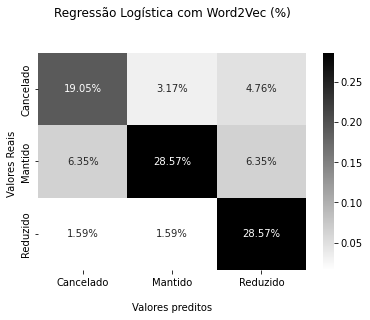

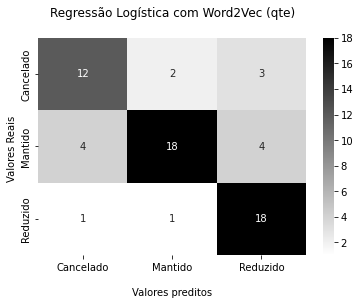

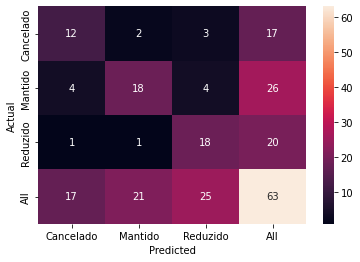

In [146]:
algoritmo(LogisticRegression(solver = "saga", multi_class='ovr', max_iter = 7000), 1, 'Regressão Logística')

Mantido 
 26 
 Reduzido 
 20

 Acurácia:  0.7142857142857143

Relatório de Classificação

               precision    recall  f1-score   support

   Cancelado       0.71      0.59      0.65        17
     Mantido       0.77      0.77      0.77        26
    Reduzido       0.65      0.75      0.70        20

    accuracy                           0.71        63
   macro avg       0.71      0.70      0.70        63
weighted avg       0.72      0.71      0.71        63



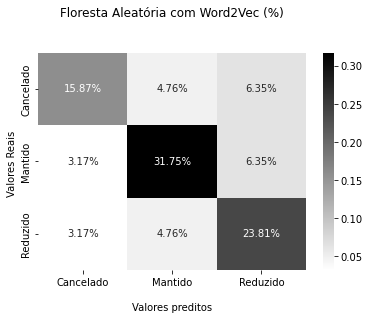

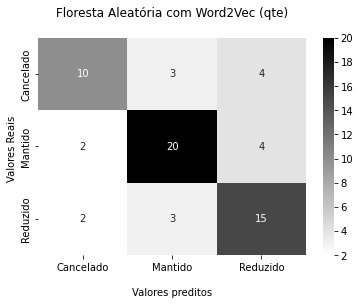

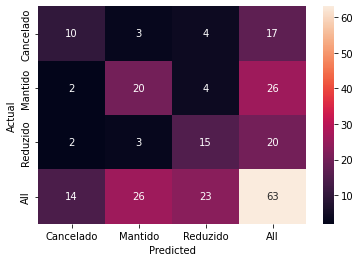

In [147]:
from sklearn.ensemble import RandomForestClassifier
#algoritmo(RandomForestClassifier())
algoritmo(RandomForestClassifier(n_estimators=350,criterion='gini',max_depth=50,max_features=300, max_samples=189),1,'Floresta Aleatória')

# Modelos AP

## Criação base treino e teste

In [148]:
# Trocar os indices para ficar igual aos modelos AM
new_data = { 0:1,
             1:2,
             2:0}
  
# combine this new data with existing DataFrame
df['decisao_dig2'] = df['decisao_dig'].map(new_data)

In [149]:
x=df['Defesa_limpa']
y=df['decisao_dig2']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = .8, random_state=0)

## Vetorização

In [150]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer 
#Tokenizer is fit on training data only, and that is used to tokenize both train and test data. 
tokenizer = Tokenizer(num_words=30000) 
tokenizer.fit_on_texts(x_train) 
train_sequences = tokenizer.texts_to_sequences(x_train) #Converting text to a vector of word indexes 
test_sequences = tokenizer.texts_to_sequences(x_test) 
#train_sequences = tokenizer.texts_to_matrix(x_train, mode='tfidf')
#test_sequences = tokenizer.texts_to_matrix(x_test, mode='tfidf')
word_index = tokenizer.word_index 
print('Found %s unique tokens.' % len(word_index))

Found 41228 unique tokens.


In [151]:
x_train = pad_sequences(train_sequences, maxlen=6000)
x_test = pad_sequences(test_sequences, maxlen=6000)
y_train = to_categorical(np.asarray(y_train))
y_test = to_categorical(np.asarray(y_test))

## CNN sem word embedding pré-treinada 

In [152]:
#======================================================================================================
def define_modelB(vocab_size, max_length):
  modelB = Sequential()
  #model.add(e)
  modelB.add(Embedding(vocab_size, 200, input_length=max_length))
  modelB.add(Conv1D(64, 15, activation='relu'))
  modelB.add(Conv1D(128, 15, activation='relu'))
  modelB.add(Conv1D(128, 15, activation='relu'))
  modelB.add(GlobalMaxPooling1D())  
  modelB.add(Dropout(0.5))
  modelB.add(Dense(3, activation='softmax'))
 
  # compile network
  modelB.compile(loss='categorical_crossentropy',  optimizer=keras.optimizers.Adam(learning_rate=0.0001),  metrics=['accuracy', 'Precision', 'Recall'])

  return modelB

In [153]:
modelB=define_modelB(30000, 6000)
# summarize defined model
modelB.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 6000, 200)         6000000   
                                                                 
 conv1d_9 (Conv1D)           (None, 5986, 64)          192064    
                                                                 
 conv1d_10 (Conv1D)          (None, 5972, 128)         123008    
                                                                 
 conv1d_11 (Conv1D)          (None, 5958, 128)         245888    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

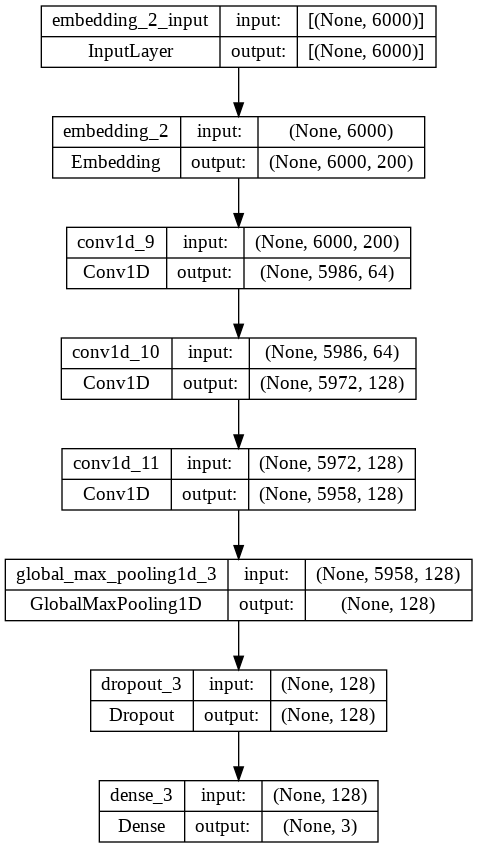

In [154]:
plot_model(modelB, to_file='modelB.png', show_shapes=True)

In [155]:
# as sementes ajudam a ter resultados reproduzíveis
from numpy.random import seed
from tensorflow.random import set_seed
#semente do numpy
seed(1)
#semente do tensorflow
set_seed(1)
# fit network
epochs = 200
batch_size=200
# fit network
from tensorflow.keras.utils import plot_model

histB=modelB.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test,y_test), verbose=2)
# evaluate
#loss, acc = model.evaluate(x_train, y_train, verbose=0)
#print('Traint Accuracy: %f' % (acc*100))

Epoch 1/200
2/2 - 2s - loss: 1.0938 - accuracy: 0.3492 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0923 - val_accuracy: 0.4286 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 2s/epoch - 778ms/step
Epoch 2/200
2/2 - 0s - loss: 1.0878 - accuracy: 0.4246 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0885 - val_accuracy: 0.6190 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 180ms/epoch - 90ms/step
Epoch 3/200
2/2 - 0s - loss: 1.0799 - accuracy: 0.4206 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0848 - val_accuracy: 0.4921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 186ms/epoch - 93ms/step
Epoch 4/200
2/2 - 0s - loss: 1.0708 - accuracy: 0.4841 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0812 - val_accuracy: 0.4286 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 178ms/epoch - 89ms/step
Epoch 5/200
2/2 - 0s - loss: 1.0679 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0778

In [156]:
# evaluate
loss, acc, precision, recall = modelB.evaluate(x_test, y_test, verbose=0)
print('Traint Accuracy: %f' % (acc*100), 'loss %f' % (loss*100), 'precisão %f' % (precision*100), 'revocação %f' % (recall*100))

Traint Accuracy: 76.190478 loss 77.914733 precisão 85.365856 revocação 55.555558


Text(0, 0.5, 'perda')

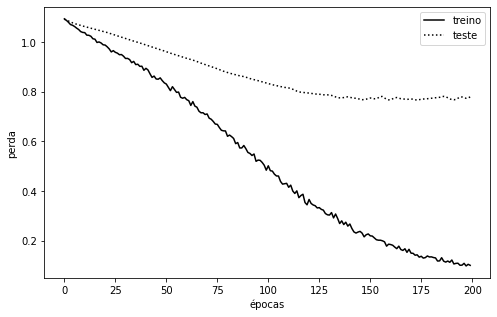

In [157]:
#grafico da perda - a distancia entre as curvas é o chamado generalization gap
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(histB.history['loss'],'k')
plt.plot(histB.history['val_loss'],'k:')
plt.legend(["treino", "teste"], loc="upper right")
plt.xlabel('épocas')
plt.ylabel('perda')

Text(0, 0.5, 'acuracia')

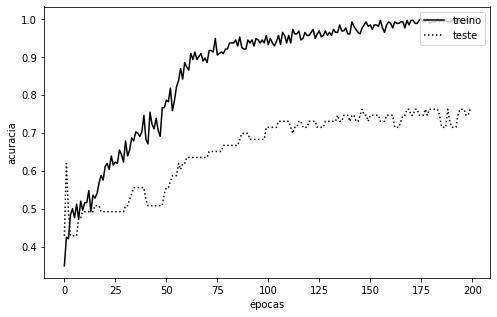

In [158]:
#grafico do acurácia - a distancia entre as curvas é o chamado generalization gap
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(histB.history['accuracy'],'k')
plt.plot(histB.history['val_accuracy'],'k:')
plt.legend(["treino", "teste"], loc="upper right")
plt.xlabel('épocas')
plt.ylabel('acuracia')

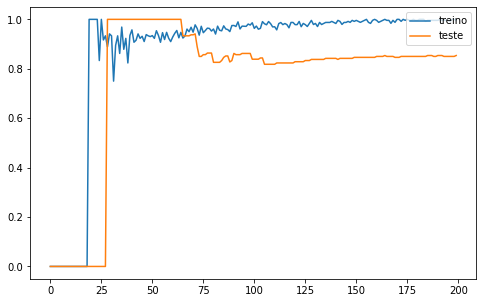

In [159]:
#grafico da precisão - a distancia entre as curvas é o chamado generalization gap
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(histB.history['precision'])
plt.plot(histB.history['val_precision'])
plt.legend(["treino", "teste"], loc="upper right")

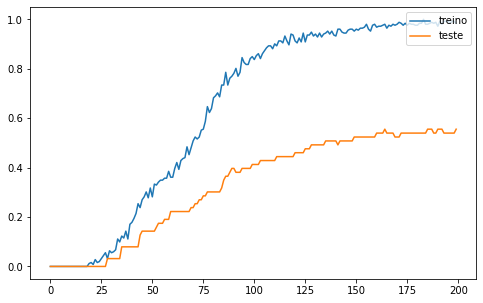

In [160]:
#grafico da revocação - a distancia entre as curvas é o chamado generalization gap
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(histB.history['recall'])
plt.plot(histB.history['val_recall'])
plt.legend(["treino", "teste"], loc="upper right")

### Função de classificação AP

In [161]:
# função de classificação AP

def modeloap(nome,y_pred_class):
  from sklearn.naive_bayes import MultinomialNB
  from sklearn.linear_model import LogisticRegression
  from sklearn.tree import DecisionTreeClassifier
  from sklearn import svm
  from sklearn.ensemble import RandomForestClassifier

  y_true=np.argmax(y_test, axis=-1)

  # Classification metrics
  from sklearn.metrics import accuracy_score, classification_report
  classification_report = classification_report(y_true, y_pred_class)

  print('\n Acurácia: ', accuracy_score(y_true, y_pred_class))
  print('\nRelatório da classificação')
  print('======================================================')
  print('\n', classification_report)


  # matriz de confusão
  cf_matrix=confusion_matrix(y_true, y_pred_class)#, labels=["Cancelado","Mantido","Reduzido"])
  ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='gray_r')
  
  ax.set_title(nome + ' - Matriz de Confusão (%)\n\n');
  ax.set_xlabel('\nValores preditos ')
  ax.set_ylabel('Valores reais ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(["Cancelado","Mantido","Reduzido"])
  ax.yaxis.set_ticklabels(["Cancelado","Mantido","Reduzido"])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

  print('\n')

  # matriz de confusão 2
  cf_matrix=confusion_matrix(y_true, y_pred_class)
  ax = sns.heatmap(cf_matrix, annot=True, cmap='gray_r')
  
  ax.set_title(nome + ' - Matriz de Confusão (qte)\n\n');
  ax.set_xlabel('\nValores preditos')
  ax.set_ylabel('Valores reais ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(["Cancelado","Mantido","Reduzido"])
  ax.yaxis.set_ticklabels(["Cancelado","Mantido","Reduzido"])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

  print('\n')

  import seaborn as sn
  conf_matrix = pd.crosstab(y_true, y_pred_class, rownames=['Actual'], colnames=['Predicted'], margins=True)

  sn.heatmap(conf_matrix, annot=True)
  plt.show()
 

2/2 [==============================] - 0s 9ms/step

 Acurácia:  0.7619047619047619

Relatório da classificação

               precision    recall  f1-score   support

           0       0.91      0.59      0.71        17
           1       0.70      0.88      0.78        26
           2       0.79      0.75      0.77        20

    accuracy                           0.76        63
   macro avg       0.80      0.74      0.75        63
weighted avg       0.78      0.76      0.76        63



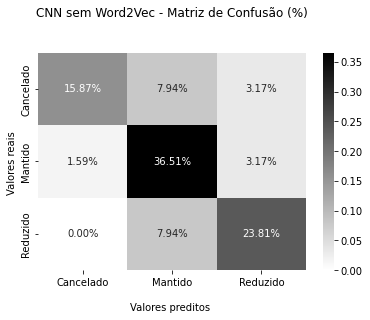

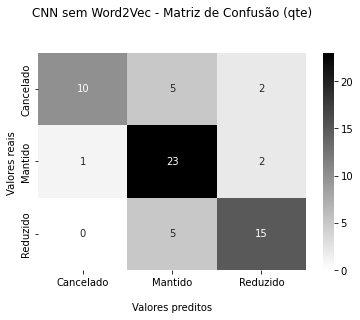

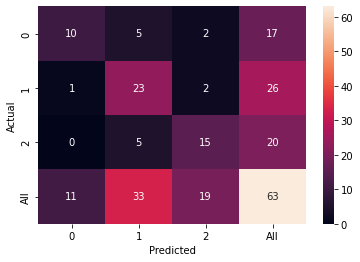

In [162]:
y_pred=modelB.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
modeloap('CNN sem Word2Vec',y_pred_class)

## CNN com word embedding pré-treinada

### Criação base treino e teste

In [163]:
x=df['Defesa_limpa']
y=df['decisao_dig2']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = .8, random_state=0)

In [164]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer 
#Tokenizer is fit on training data only, and that is used to tokenize both train and test data. 
tokenizer = Tokenizer(num_words=30000) 
tokenizer.fit_on_texts(x_train) 
train_sequences = tokenizer.texts_to_sequences(x_train) #Converting text to a vector of word indexes 
test_sequences = tokenizer.texts_to_sequences(x_test) 
#train_sequences = tokenizer.texts_to_matrix(x_train, mode='tfidf')
#test_sequences = tokenizer.texts_to_matrix(x_test, mode='tfidf')
word_index = tokenizer.word_index 
print('Found %s unique tokens.' % len(word_index))

Found 41228 unique tokens.


In [165]:
x_train = pad_sequences(train_sequences, maxlen=6000)
x_test = pad_sequences(test_sequences, maxlen=6000)
y_train = to_categorical(np.asarray(y_train))
y_test = to_categorical(np.asarray(y_test))

In [166]:
print('Preparing embedding matrix.')

# first, build index mapping words in the embeddings set to their embedding vector

embeddings_index = {}
with open('/content/drive/MyDrive/curso_word2vec/cbow_s300.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])
        embeddings_index[word] = coefs

Preparing embedding matrix.


In [167]:
print('Found %s word vectors in CBOWs_300 embeddings.' % len(embeddings_index))
print(len(embeddings_index["impugnante"]))

Found 929595 word vectors in CBOWs_300 embeddings.
300


In [168]:
len(word_index.items())

41228

In [169]:
len(embeddings_index.get('impugnante'))

300

In [170]:
# prepare embedding matrix - rows are the words from word_index, columns are the embeddings of that word from glove.
MAX_NUM_WORDS=30000
MAX_SEQUENCE_LENGTH=6000
EMBEDDING_DIM=300
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and len(embedding_vector)==300:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load these pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
print("Preparing of embedding matrix is done")

Preparing of embedding matrix is done


In [171]:
#=========================================================================================================
def define_modelB1(vocab_size, max_length):
  modelB1 = Sequential()
  #model.add(e)
  modelB1.add(embedding_layer)
  modelB1.add(Conv1D(64, 15, activation='relu'))
  modelB1.add(Conv1D(128, 15, activation='relu'))
  modelB1.add(Conv1D(128, 15, activation='relu'))
  modelB1.add(GlobalMaxPooling1D())  
  modelB1.add(Dropout(0.5))
  modelB1.add(Dense(3, activation='softmax'))
  # compile network
  modelB1.compile(loss='categorical_crossentropy',  optimizer=keras.optimizers.Adam(learning_rate=0.0001),  metrics=['accuracy', 'Precision', 'Recall'])
  # summarize defined model
  
  return modelB1

In [172]:
modelB1=define_modelB1(30000, 5000)
modelB1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 6000, 300)         9000300   
                                                                 
 conv1d_12 (Conv1D)          (None, 5986, 64)          288064    
                                                                 
 conv1d_13 (Conv1D)          (None, 5972, 128)         123008    
                                                                 
 conv1d_14 (Conv1D)          (None, 5958, 128)         245888    
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                      

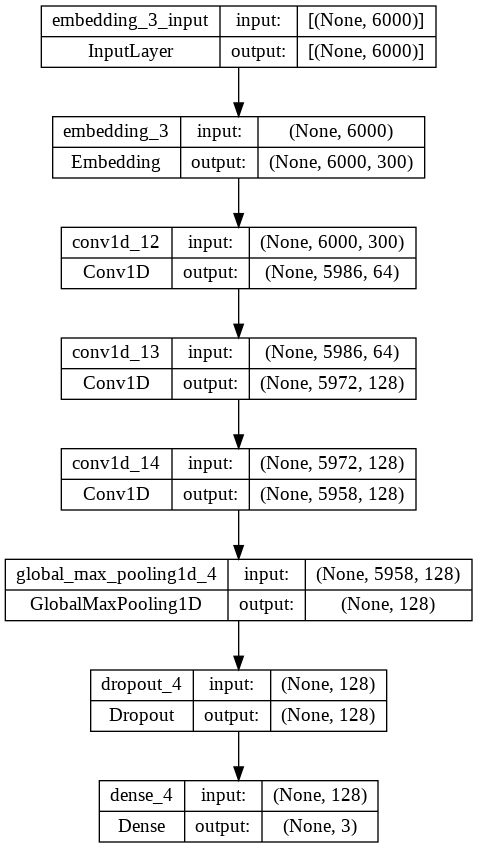

In [173]:
plot_model(modelB1, to_file='modelB.png', show_shapes=True)

In [174]:
# as sementes ajudam a ter resultados reproduzíveis
from numpy.random import seed
from tensorflow.random import set_seed
#semente do numpy
seed(2)
#semente do tensorflow
set_seed(2)
# fit network
epochs = 200
batch_size=200
# fit network
from tensorflow.keras.utils import plot_model
modelB1=define_modelB1(30000, 5000)
histB1=modelB1.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test,y_test), verbose=2)

Epoch 1/200
2/2 - 1s - loss: 1.0970 - accuracy: 0.3810 - precision: 0.4407 - recall: 0.1032 - val_loss: 1.0703 - val_accuracy: 0.4286 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 1s/epoch - 728ms/step
Epoch 2/200
2/2 - 0s - loss: 1.1133 - accuracy: 0.3889 - precision: 0.3846 - recall: 0.0794 - val_loss: 1.0649 - val_accuracy: 0.5397 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 190ms/epoch - 95ms/step
Epoch 3/200
2/2 - 0s - loss: 1.0465 - accuracy: 0.4325 - precision: 0.5294 - recall: 0.0714 - val_loss: 1.0584 - val_accuracy: 0.5238 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 169ms/epoch - 85ms/step
Epoch 4/200
2/2 - 0s - loss: 1.0178 - accuracy: 0.4921 - precision: 0.6552 - recall: 0.0754 - val_loss: 1.0499 - val_accuracy: 0.5397 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 177ms/epoch - 88ms/step
Epoch 5/200
2/2 - 0s - loss: 1.0259 - accuracy: 0.4841 - precision: 0.6154 - recall: 0.0952 - val_loss: 1.0383 - val_accuracy: 0.5556 - val_precision:

In [175]:
# evaluate
score = modelB1.evaluate(x_test, y_test, verbose=0)
print(modelB1.metrics_names[0], score[0])
print(modelB1.metrics_names[1], score[1])
print(modelB1.metrics_names[2], score[2])
print(modelB1.metrics_names[3], score[3])

#print('Traint Accuracy: %f' % (score*100))

loss 0.7667757272720337
accuracy 0.7301587462425232
precision 0.8536585569381714
recall 0.5555555820465088


Text(0, 0.5, 'perda')

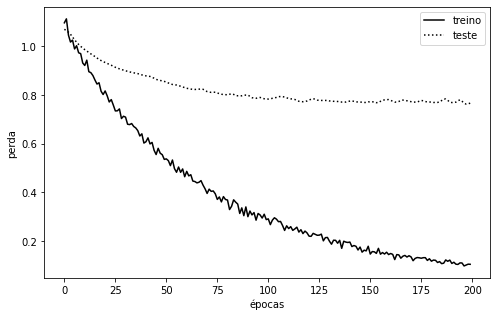

In [176]:
#grafico do learning rate - a distancia entre as curvas é o chamado generalization gap
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(histB1.history['loss'],'k')
plt.plot(histB1.history['val_loss'],'k:')
plt.legend(["treino", "teste"], loc="upper right")
plt.xlabel('épocas')
plt.ylabel('perda')

Text(0, 0.5, 'acuracia')

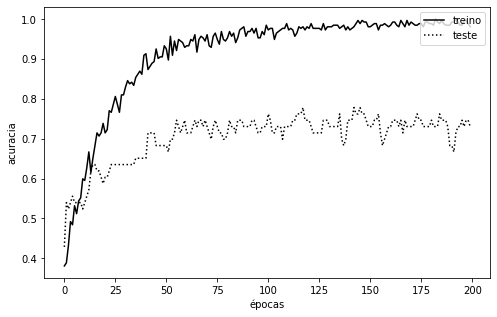

In [177]:
#grafico do learning rate - a distancia entre as curvas é o chamado generalization gap
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(histB1.history['accuracy'],'k')
plt.plot(histB1.history['val_accuracy'],'k:')
plt.legend(["treino", "teste"], loc="upper right")
plt.xlabel('épocas')
plt.ylabel('acuracia')

2/2 [==============================] - 0s 10ms/step

 Acurácia:  0.7301587301587301

Relatório da classificação

               precision    recall  f1-score   support

           0       0.75      0.53      0.62        17
           1       0.69      0.85      0.76        26
           2       0.79      0.75      0.77        20

    accuracy                           0.73        63
   macro avg       0.74      0.71      0.72        63
weighted avg       0.74      0.73      0.72        63



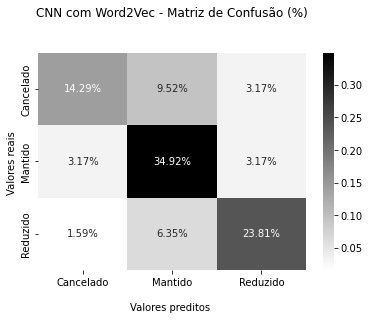

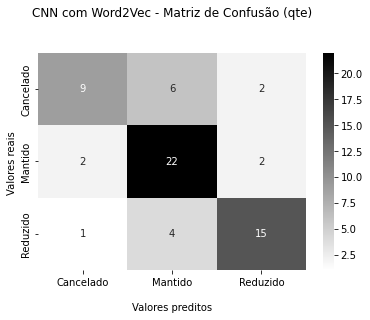

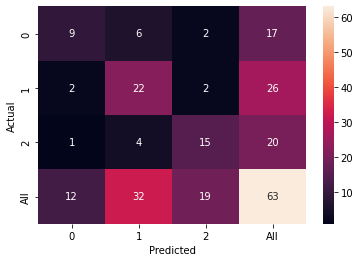

In [178]:
y_pred=modelB1.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
modeloap('CNN com Word2Vec',y_pred_class)